# Panel data regression
Since pest pressure data set is in panel data form the most appropriate approach for modelling is to build a panel data regression.

We can choose one of these three types of regressions:
1. Fixed effect regression
2. Rando effect regression
3. mixed effect regression

“When a sample exhausts the population, the corresponding variable is fixed; when the sample is a small (i.e., negligible) part of the population the corresponding variable is random.” (Green and Tukey, 1960)

I will use LM & Hausman tests for random effectness across the cros-sections ( traps)

### Feature Selection
* **location**: The trap count may be affected by the location of the fields due to climate and other environmental factors. 
        
         For this we could cluster the fields based on their coordinates using a clustering algorithm such KNN and use the clusters as predictor, but since we have a limited sample size we should go with a simpler model.
         
 * **time_delta**: which is the time passed since the last time sticky sheet is replaced. Since sticky sheets loose their ability capture pests in time this should have a negative impact in the trap count
 
 * **Crop type** may have an impact in the trap count
 * **trap_id_id **: This is the cross section variable in the panel data
 * **date**: This is the time feature of the panel data
         



In [294]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Modelling Packages
# Stats, Supervised
import statsmodels.api as sm
# linearmodels is an extension package to statsmodel 
# which includes panel data regression along with some other methods
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.panel.results import compare
from linearmodels import PooledOLS
# Unsupervised
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

#Geospatial Methods
import geopandas as gpd

from shapely.geometry import Point
import cartopy
import cartopy.crs as ccrs
import geoplot as gplt
import geoplot.crs as gcrs

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
crs=ccrs.PlateCarree()
from geopandas_view import view

In [295]:
df = pd.read_csv('data/pest_pressure_3day.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      206 non-null    object 
 1   crop_name                 206 non-null    object 
 2   region                    42 non-null     object 
 3   pest                      58 non-null     object 
 4   trap_count                206 non-null    float64
 5   is_sticky_sheet_replaced  58 non-null     object 
 6   lat                       206 non-null    float64
 7   lon                       206 non-null    float64
 8   time_delta                206 non-null    float64
 9   trap_id_id                206 non-null    int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 16.2+ KB


# Feature Engineering For Panel Regression
* Create clusters for geogpraphical locations using KNN
* Transform categorical variables as object type
* set trap_id and date to index
### Geographical Clusters

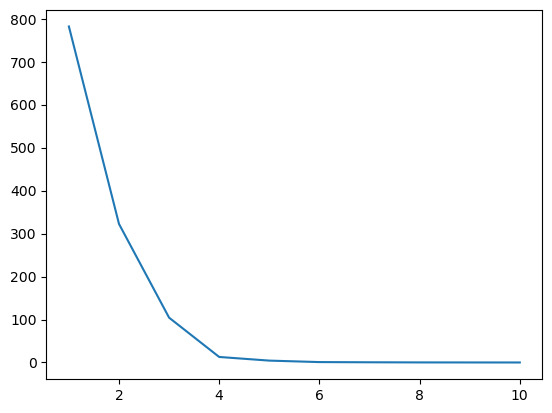

In [296]:
X = df [['lat','lon']]
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
_ = plt.plot(range(1, 11), wcss)

In [297]:
# 1. K Means Clustering
print('Silhouette Scores')
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
KMcluster_labels = kmeans.predict(X)
print(f'KMeans: {silhouette_score(X, KMcluster_labels)}')

# 2. GMM 
X = df [['lat','lon']]
n_clusters = 4
gmm_model = GaussianMixture(n_components=n_clusters)
gmm_model.fit(X)
GMMcluster_labels = gmm_model.predict(X)
print(f'GMM: {silhouette_score(X, GMMcluster_labels)}')

# 3. #DBSCAN Clustering
from sklearn.cluster import DBSCAN
cl4 = DBSCAN(min_samples=3)
cl4_labels = cl4.fit_predict(X)
cl4_sil_sc = silhouette_score(X, cl4_labels)
print(f'DBSCAN: {cl4_sil_sc}')

# 4. Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
cl3 = AgglomerativeClustering(n_clusters=4)
cl3.fit(X)
cl3_sil_sc = silhouette_score(X, cl3.labels_)
print(f"Agglomerative Clustering: {cl3_sil_sc}")

# 5. #Spectral Clustering
from sklearn.cluster import SpectralClustering
cl2 = SpectralClustering(n_clusters=4)
cl2.fit(X)
cl2_sil_sc = silhouette_score(X, cl2.labels_)
print(f"Spectral Clustering: {cl2_sil_sc}")


Silhouette Scores
KMeans: 0.8901672484339652
GMM: 0.8901672484339652
DBSCAN: 0.8901672484339652
Agglomerative Clustering: 0.8901672484339652
Spectral Clustering: 0.8901672484339652


I tried 5 different clustering algorithm, and they all produce identical clusters. We can now confidenly use these clusters as our geographical features.

In [298]:
# Setting cluster labels in our data
df['cluster'] = KMcluster_labels

In [309]:
df_grouped = df.reset_index().groupby(['trap_id_id','crop_name']).mean()

geometry = [Point(xy) for xy in zip(df_grouped.lon, df_grouped.lat)]
gdf = gpd.GeoDataFrame(df_grouped, crs="EPSG:4326", geometry=geometry) # df_grouped.drop(['lon', 'lat'], axis=1)
gdf.reset_index(level=1,inplace=True)
# Let's enhance the cluster values for better color mapping
gdf.loc[:,'cluster'] = gdf['cluster'].apply(str)
# gdf.loc[:,'cluster'] = gdf['cluster'].apply(lambda x: x if x==0 else 5 if x == 1 else 10 if x==2 else 20 )

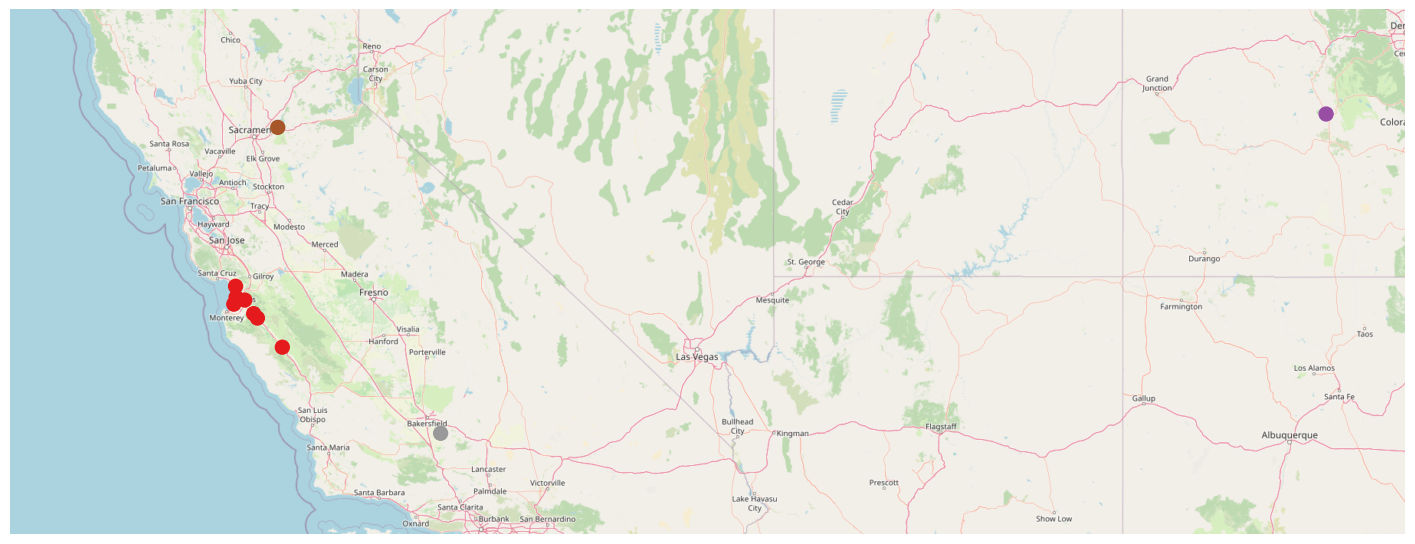

In [321]:
extent = (-125, 34, -105, 40)
# scheme = mc.Quantiles(gdf['trap_count'], k=3)
ax = gplt.pointplot(
    gdf, projection=gcrs.WebMercator(), figsize=(18, 18),s=10,
    hue='cluster',cmap='Set1'
)
ax = gplt.webmap(
    gdf, ax=ax, extent=extent
)

In [119]:
# Let's add this clusters to our data
df['cluster'] = X['cluster']

In [261]:
# We don't need all these variables. Let's drop the ones not needed
df = df[[ 'trap_id_id','date','trap_count','time_delta', 'crop_name','cluster']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   trap_id_id  206 non-null    int64  
 1   date        206 non-null    object 
 2   trap_count  206 non-null    float64
 3   time_delta  206 non-null    float64
 4   crop_name   206 non-null    object 
 5   cluster     206 non-null    int32  
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 9.0+ KB


In [262]:
df.trap_id_id.value_counts()

112    25
27     24
94     24
100    24
110    24
84     23
108    22
93     21
89     17
114     2
Name: trap_id_id, dtype: int64

In [263]:
# Converting trap_id_id to object
df.loc[:,'trap_id_id'] = df['trap_id_id'].astype(str)
# Create a categorical version of date field.
df.loc[:,'Date'] = pd.Categorical(df['date'])

#Set index to trap_id_id and date
df.loc[:,'date'] = pd.to_datetime(df['date'])
df = df.set_index(['trap_id_id','date'])

# Create a dummy variable for crop_name
# We don't need both Broccoli and Brussel sprouts as dummy variables. We can assign 1 for Broccoli and 0 for the other
df = pd.get_dummies(df, columns=['crop_name'],drop_first=True,
               prefix='',prefix_sep='')

In [267]:
df

trap_count  time_delta  cluster        Date  \
trap_id_id date                                                      
27         2020-05-25   79.000000    4.000000        3  2020-05-25   
           2020-05-28  103.750000    4.000000        3  2020-05-28   
           2020-05-31   78.666667    3.333333        3  2020-05-31   
           2020-06-03   59.000000    5.000000        3  2020-06-03   
           2020-06-06   52.333333    5.666667        3  2020-06-06   
...                           ...         ...      ...         ...   
112        2020-07-20   21.571429   10.000000        0  2020-07-20   
           2020-07-23   15.142857   13.000000        0  2020-07-23   
           2020-07-26   27.666667   16.000000        0  2020-07-26   
114        2020-07-30   16.000000    7.000000        1  2020-07-30   
           2020-08-02   19.750000   10.000000        1  2020-08-02   

                       Brussels sprout  
trap_id_id date                         
27         2020-05-25                0  
           2020-05-28                0  
           2020-05-31                0  
           2020-06-03                0  
           2020-06-06                0  
...                                ...  
112        2020-07-20                1  
           2020-07-23                1  
           2020-07-26                1  
114        2020-07-30                0  
           2020-08-02                0  

[206 rows x 5 columns]

### Collinearity Check

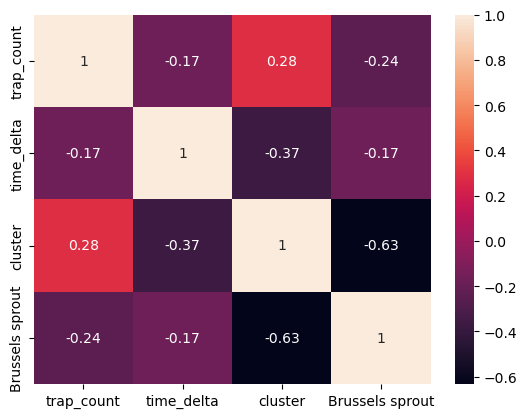

In [268]:
g = sns.heatmap(df.corr(),annot=True)

We don't have many variables, we couldn't afford to remove any of them in case there is a high collinearity. Nevertheless there is not much collinearity in the data except between Brussel Sprout and cluster, which was expected.

## Pooled OLS

In [283]:
exog = sm.tools.tools.add_constant(df[['Brussels sprout','time_delta','cluster']])
endog = df['trap_count']
# Pooled OLS model
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids
print(pooledOLS_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:             trap_count   R-squared:                        0.1065
Estimator:                  PooledOLS   R-squared (Between):              0.1257
No. Observations:                 206   R-squared (Within):              -0.0009
Date:                Wed, Aug 24 2022   R-squared (Overall):              0.1065
Time:                        03:00:01   Log-likelihood                   -1090.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.0235
Entities:                          10   P-value                           0.0000
Avg Obs:                       20.600   Distribution:                   F(3,202)
Min Obs:                       2.0000                                           
Max Obs:                       25.000   F-statistic (robust):             1.1911
                            

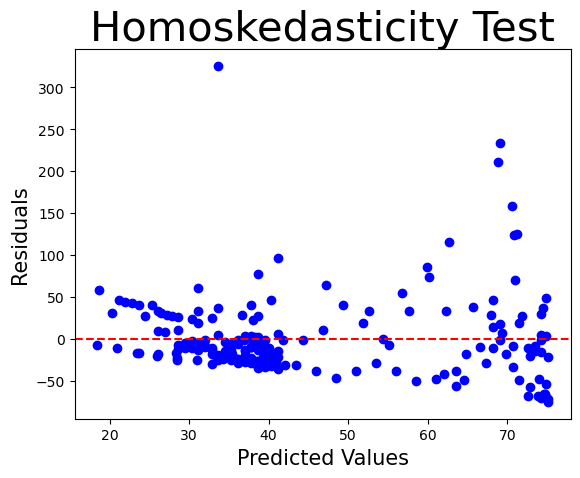

In [282]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

We have growing variance which means heteroskedasticity. This is a violation OLS which suggest that unobserved variables correlated with the error. Random, or fixed effect model seems more appropriate.

In [285]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson
pooled_OLS_dataset = pd.concat([df, residuals_pooled_OLS], axis=1)
durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

0.8956721006555335


Durbin Watson test result is between 0-2 which suggest positive autocorrelation. This also violetes the assumption of linear regression. Hence, I will move to Random/fixed effect models

## Fixed and Random Effect Regression

In [271]:
exog = sm.tools.tools.add_constant(df[['Brussels sprout','time_delta','cluster']])
endog = df['trap_count']
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
#print results
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:             trap_count   R-squared:                        0.0113
Estimator:              RandomEffects   R-squared (Between):              0.1566
No. Observations:                 206   R-squared (Within):               0.0059
Date:                Wed, Aug 24 2022   R-squared (Overall):              0.0986
Time:                        02:52:18   Log-likelihood                   -1053.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.7712
Entities:                          10   P-value                           0.5114
Avg Obs:                       20.600   Distribution:                   F(3,202)
Min Obs:                       2.0000                                           
Max Obs:                       25.000   F-statistic (robust):             0.8671
                            

In [49]:
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:             trap_count   R-squared:                        0.0108
Estimator:              RandomEffects   R-squared (Between):              0.1182
No. Observations:                 206   R-squared (Within):               0.0058
Date:                Wed, Aug 24 2022   R-squared (Overall):              0.0866
Time:                        00:28:59   Log-likelihood                   -1054.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.1117
Entities:                          10   P-value                           0.3310
Avg Obs:                       20.600   Distribution:                   F(2,203)
Min Obs:                       2.0000                                           
Max Obs:                       25.000   F-statistic (robust):             1.2683
                            

In [273]:
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True, drop_absorbed=True) 
fe_res = model_fe.fit() 
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:             trap_count   R-squared:                        0.0059
Estimator:                   PanelOLS   R-squared (Between):              0.0251
No. Observations:                 206   R-squared (Within):               0.0059
Date:                Wed, Aug 24 2022   R-squared (Overall):              0.0214
Time:                        02:53:22   Log-likelihood                   -1050.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.1649
Entities:                          10   P-value                           0.2818
Avg Obs:                       20.600   Distribution:                   F(1,195)
Min Obs:                       2.0000                                           
Max Obs:                       25.000   F-statistic (robust):             1.1649
                            

In [288]:
compare({'Pooled': pooledOLS_res,
"Random effect":re_res,
"Fixed Effect": fe_res})

,Pooled,Random effect,Fixed Effect
Dep. Variable,trap_count,trap_count,trap_count
Estimator,PooledOLS,RandomEffects,PanelOLS
No. Observations,206,206,206
Cov. Est.,Clustered,Unadjusted,Unadjusted
R-squared,0.1065,0.0113,0.0346
R-Squared (Within),-0.0009,0.0059,-0.0097
R-Squared (Between),0.1257,0.1566,0.0331
R-Squared (Overall),0.1065,0.0986,0.0247
F-statistic,8.0235,0.7712,4.4093
P-value (F-stat),0.0000,0.5114,0.0378


## Conclusion

Because of the the very limited sample size, None of the models produced statistically significant fits to the data to explain the variance in trap_counts. 

* To improve the model performance more data should be collected. 
* Moreover, some more variables could be added to the data such as:
    Weather conditions,events. For instance, there may be a correlation between the temperature and the pest population, or the extreme weather events like heavy rain, flood, heat waves etc.
* When there is a spike in trap counts we usually see sharp decline in the data. This may be due to the pest treatments after pest population increase. If this data was collected, (whether pestisize, adultisize, applied to the field or not.) this will probably help explaining the variance in trap counts. 
